In [52]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# import MC_autocall

# Parameters
S0 = 100  # Initial price of the underlying asset
sigma = 0.2  # Annual volatility of the asset
r = 0.05  # Annual risk-free rate
T = 1  # Maturity of the product in years
m = 300  # Number of observation dates
n = 8*10**4 # Number of Monte Carlo simulations
yield_rate = 0.06  # Coupon yield rate
barrier = 0.8  # Barrier level as a percentage of the initial level


def Observation(n, m, S0, r, sigma, T, observation_points=12, Z=None):
    # Time points for each observation
    dt = T / m
    total_time_points = np.linspace(0, T, m+1)  # Total subdivisions including 0

    # Generate standard Brownian motion paths (n, subdivisions)
    if Z is None:
        W_t = np.random.randn(n, m) * np.sqrt(dt)  # Generate new if not provided
    else:
        W_t = Z * np.sqrt(dt)

    W_t = np.hstack((np.zeros((n, 1)), np.cumsum(W_t, axis=1)))  # Cumulative sum to simulate the Brownian motion paths, starting with 0

    # Calculate asset price at each time point using the Black-Scholes formula
    exponent = (r - 0.5 * sigma**2) * total_time_points + sigma * W_t  # Use all time points including 0
    paths = S0 * np.exp(exponent)

    # Extract the asset prices at the desired observation points
    if observation_points <= m+1:  # Ensure valid number of observation points
        observation_indices = np.round(np.linspace(0, m, observation_points)).astype(int)  # Indices for observation, rounded to ensure integers
    else:
        raise ValueError("observation_points should be less than or equal to the number of time subdivisions (m+1)")
    Obs = paths[:, observation_indices]
    return Obs



def autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, Z=None, observation_points=12):
    """
    Calculate the payoff for each simulation path of the autocallable product.
    This function determines the payoff based on the occurrence of early termination and the final asset price relative to the barrier.
    """
    observation = Observation(n, m, S0, r, sigma, T, observation_points, Z)  # Generate asset paths
    payoffs = []
    for path in observation:
        early_termination = False
        for t in range(1, observation_points):  # Loop over each observation date, up to the second-to-last element
            if path[t] > S0:  # Check for early termination condition
                payoffs.append((1 + yield_rate * t))  # Calculate payoff for early termination
                early_termination = True
                break
        if not early_termination:  # If no early termination
            if path[-1] < barrier * S0:  # If asset price is below the barrier at maturity
                payoffs.append(path[-1] / S0)  # Payoff is the negative performance
            else:  # If asset price is above the barrier
                payoffs.append(1)  # No payoff as the asset price is above the barrier
    return np.array(payoffs)



def MC_autocall(S0, barrier, yield_rate, n, m, r, sigma, T, Z=None, observation_points=12):
    """
    Perform Monte Carlo simulation to calculate the average expected payoff of the autocallable product.
    This function averages the payoffs from all simulation paths and discounts them to present value.
    """
    payoffs = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)  # Calculate payoffs for each path
    return np.mean(payoffs) * np.exp(-r * T)  # Discount payoffs to present value and calculate average

def MC_confidence(S0, barrier, yield_rate, n, m, r, sigma, T, Z=None, observation_points=12):
    """
    Give some information about the monte carlo estimator (standard dev, confidence interval, error)
    """
    payoffs = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points) 
    p = np.mean(payoffs) * np.exp(-r * T) 
    s = np.std(payoffs*np.exp(-r*T))
    print("Estimator:", p)
    print("Standard deviation:", s/np.sqrt(n)) 
    print("Confidence interval 95%:", [p-1.96*s/np.sqrt(n), p+1.96*s/np.sqrt(n)])  # Confidence interval of level 95%
    print("Error:", 100*1.96*s/(p*np.sqrt(n)), "%")

    
def calculate_delta(S0, barrier, yield_rate, n, m, r, sigma, T, delta_S=0.1, Z=None, observation_points=12):
    # Check if Z is None and then generate a single sample of gaussian v.a. for consistency
    if Z is None:
        Z = np.random.randn(n, m)
    
    # Calculate prices for the up and down scenarios
    price_up = autocall_payoff(S0 + delta_S, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)
    price_down = autocall_payoff(S0 - delta_S, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)

    # Return the Delta
    return (price_up - price_down) / (2 * delta_S)



def calculate_gamma(S0, barrier, yield_rate, n, m, r, sigma, T, delta_S=0.1, Z=None, observation_points=12):
    # Check if Z is None and then generate a single sample of gaussian v.a. for consistency
    if Z is None:
        Z = np.random.randn(n, m)
    
    # Calculate prices for the up, down, and base scenarios
    price_up = autocall_payoff(S0 + delta_S, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)
    price_down = autocall_payoff(S0 - delta_S, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)
    base_price = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)

    # Return the Gamma
    return (price_up - 2 * base_price + price_down) / (delta_S**2)



def calculate_vega(S0, barrier, yield_rate, n, m, r, sigma, T, delta_sigma=0.008, Z=None, observation_points=12):
    # Check if Z is None and then generate a single sample of gaussian v.a. for consistency
    if Z is None:
        Z = np.random.randn(n, m)
    
    # Calculate prices for the original and increased volatility scenarios
    base_price = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, Z, observation_points)
    price_vol_up = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma + delta_sigma, T, Z, observation_points)

    # Return the Vega
    return (price_vol_up - base_price) / delta_sigma



# Define any additional parameters as needed, such as Z and observation_points
Z = np.random.randn(n, m)  # For example, or use None to generate within functions

Delta = calculate_delta(S0, barrier, yield_rate, n, m, r, sigma, T, Z=Z)
Gamma = calculate_gamma(S0, barrier, yield_rate, n, m, r, sigma, T, Z=Z)
Vega = calculate_vega(S0, barrier, yield_rate, n, m, r, sigma, T, Z=Z)

print(f"In our setting, \nAverage Delta: {np.mean(Delta)} with std: {np.std(Delta)}. \nAverage Gamma: {np.mean(Gamma)} with std: {np.std(Gamma)}. \nAverage Vega: {np.mean(Vega)} with std: {np.std(Vega)}")


In our setting, 
Average Delta: -8.326672684688674e-20 with std: 7.881064101567144e-17. 
Average Gamma: -1.3322676295501873e-17 with std: 2.784808288976971e-15. 
Average Vega: -0.23139103033557576 with std: 3.621452400924434


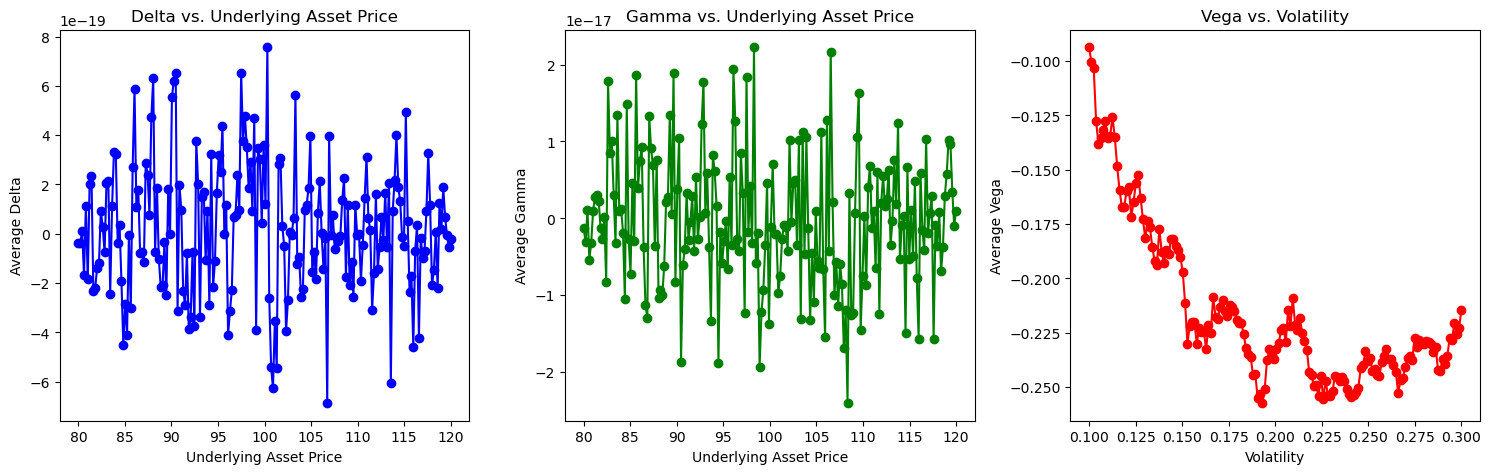

In [53]:
# Define ranges for the parameters
S_range = np.linspace(80, 120, 200)  # Range for underlying asset prices
sigma_range = np.linspace(0.1, 0.3, 160)  # Range for volatility

# Initialize lists to hold the average Greeks
average_deltas = []
average_gammas = []
average_vegas = []

# Calculate average Delta and Gamma for different values of S0
for S in S_range:
    Delta = calculate_delta(S, barrier, yield_rate, n, m, r, sigma, T, Z=Z)
    Gamma = calculate_gamma(S, barrier, yield_rate, n, m, r, sigma, T, Z=Z)
    average_deltas.append(np.mean(Delta))
    average_gammas.append(np.mean(Gamma))

# Calculate average Vega for different values of sigma
for vol in sigma_range:
    Vega = calculate_vega(S0, barrier, yield_rate, n, m, r, vol, T, Z=Z)
    average_vegas.append(np.mean(Vega))

# Plotting the results
plt.figure(figsize=(15, 5))

# Plot for Delta
plt.subplot(1, 3, 1)
plt.plot(S_range, average_deltas, '-o', color='blue')
plt.title('Delta vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Average Delta')

# Plot for Gamma
plt.subplot(1, 3, 2)
plt.plot(S_range, average_gammas, '-o', color='green')
plt.title('Gamma vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Average Gamma')

# Plot for Vega
plt.subplot(1, 3, 3)
plt.plot(sigma_range, average_vegas, '-o', color='red')
plt.title('Vega vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Average Vega')

plt.tight_layout()
plt.show()


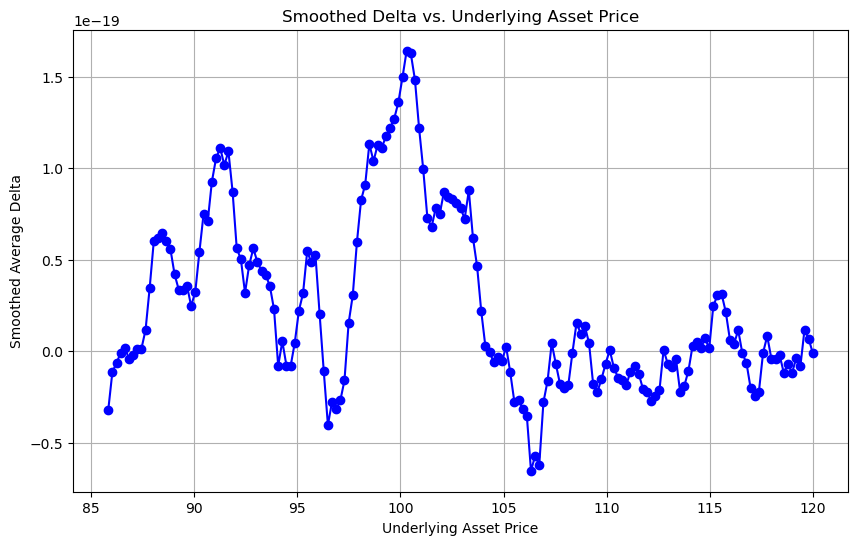

In [64]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply the moving average to your average_deltas
smoothed_average_deltas = moving_average(average_deltas, window_size=30)  # Change window_size as needed

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(S_range[len(S_range) - len(smoothed_average_deltas):], smoothed_average_deltas, '-o', color='blue')
plt.title('Smoothed Delta vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Smoothed Average Delta')
plt.grid(True)
plt.show()


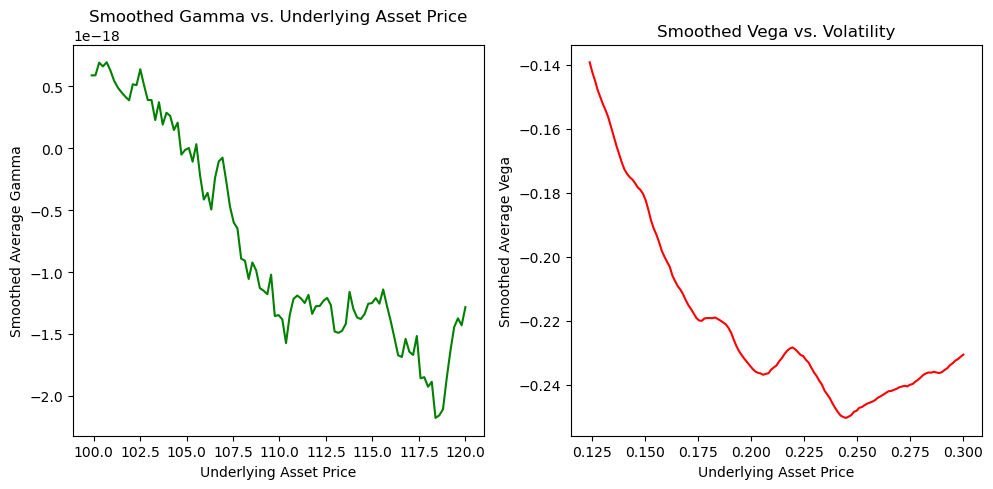

In [75]:
smoothed_average_gammas = moving_average(average_gammas, window_size=100)
smoothed_average_vegas = moving_average(average_vegas, window_size=20)

# Adjusted S_range for smoothed values due to the convolution
adjusted_S_range = S_range[len(S_range) - len(smoothed_average_gammas):]

# Adjusted sigma_range for smoothed values due to convolution
adjusted_sigma_range = sigma_range[len(sigma_range) - len(smoothed_average_vegas):]


# Plotting the results
plt.figure(figsize=(15, 5))

# Plot for Smoothed Gamma
plt.subplot(1, 3, 1)
plt.plot(adjusted_S_range, smoothed_average_gammas, color='green')
plt.title('Smoothed Gamma vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Smoothed Average Gamma')

# Plot for Smoothed Vega
plt.subplot(1, 3, 2)
plt.plot(adjusted_sigma_range, smoothed_average_vegas, color='red')
plt.title('Smoothed Vega vs. Volatility')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Smoothed Average Vega')

plt.tight_layout()
plt.show()

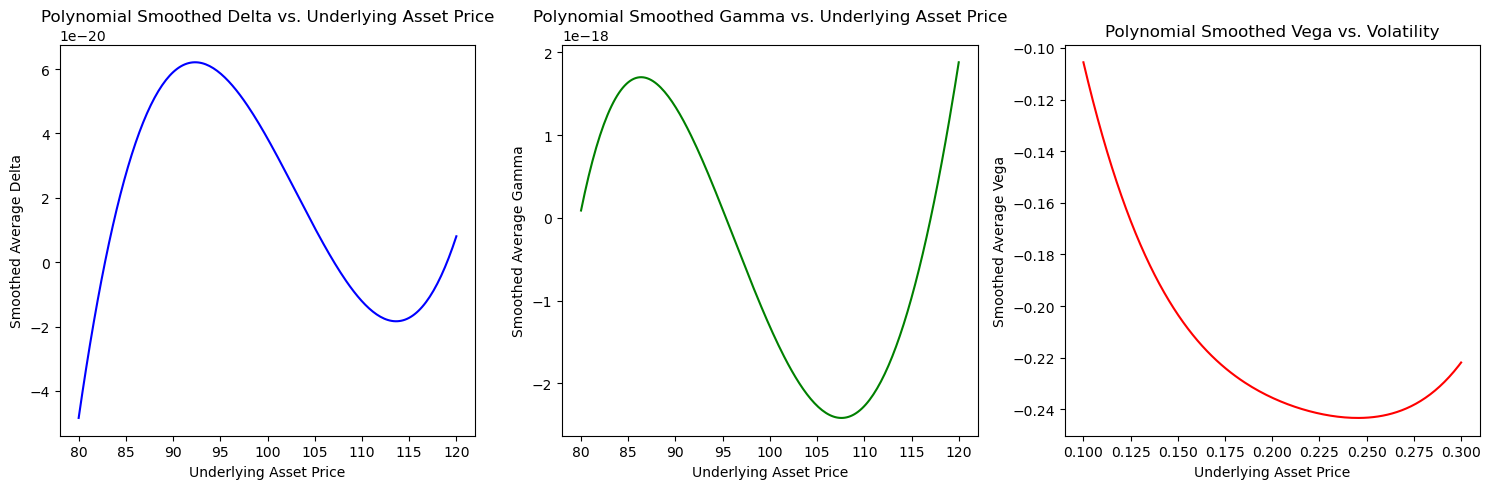

In [79]:
def polynomial_smoothing(x, y, degree=4):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    return p(x)

# Assuming S_range and the average_* arrays are defined as before
degree = 4  # Degree of the polynomial

# Apply polynomial smoothing
smoothed_average_deltas_poly = polynomial_smoothing(S_range, average_deltas, degree=degree)
smoothed_average_gammas_poly = polynomial_smoothing(S_range, average_gammas, degree=degree)
smoothed_average_vegas_poly = polynomial_smoothing(sigma_range, average_vegas, degree=degree)

# Plotting the results
plt.figure(figsize=(15, 5))

# Plot for Smoothed Delta with Polynomial
plt.subplot(1, 3, 1)
plt.plot(S_range, smoothed_average_deltas_poly, color='blue')
plt.title('Polynomial Smoothed Delta vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Smoothed Average Delta')

# Plot for Smoothed Gamma with Polynomial
plt.subplot(1, 3, 2)
plt.plot(S_range, smoothed_average_gammas_poly, color='green')
plt.title('Polynomial Smoothed Gamma vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Smoothed Average Gamma')

# Plot for Smoothed Vega with Polynomial
plt.subplot(1, 3, 3)
plt.plot(sigma_range, smoothed_average_vegas_poly, color='red')
plt.title('Polynomial Smoothed Vega vs. Volatility')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Smoothed Average Vega')

plt.tight_layout()
plt.show()

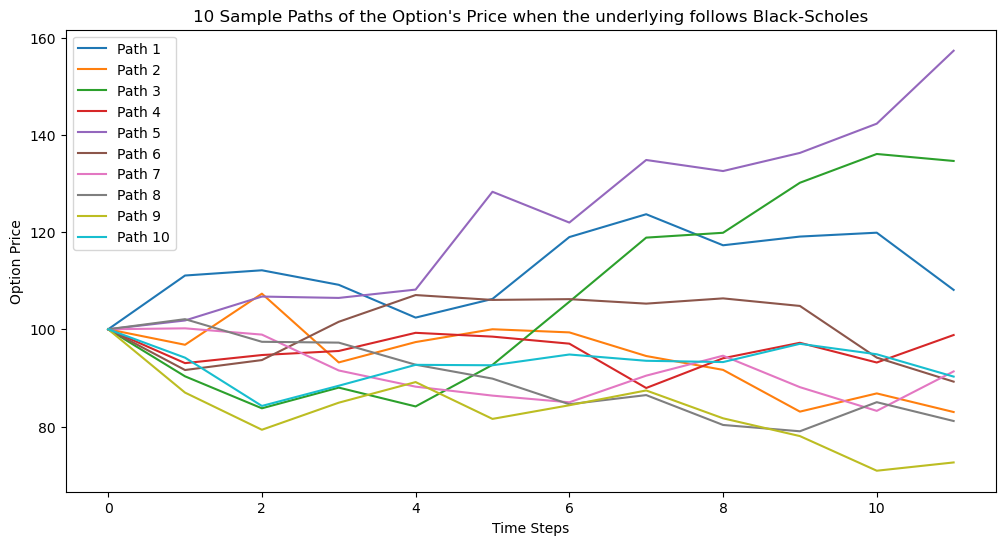

In [49]:
# Parameters
S0 = 100  # Initial price of the underlying asset
sigma = 0.2  # Annual volatility of the asset
r = 0.05  # Annual risk-free rate
T = 1  # Maturity of the product in years
m = 300  # Number of observation dates
observation_points = 12  # Number of points to extract

# Generate paths
paths = Observation(n=10, m=m, S0=S0, r=r, sigma=sigma, T=T, observation_points=observation_points)

# Plotting 10 paths
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(paths[i], label=f'Path {i+1}')
plt.title('10 Sample Paths of the underlying according  to Black-Scholes')
plt.xlabel('Time Steps')
plt.ylabel('Option Price')
plt.legend()
plt.show()